In [14]:
# Imports
import geopandas as gpd
import pandas as pd
import hvplot.pandas
import os
import pathlib
import xarray as xr
from glob import glob
import rioxarray as rxr
import matplotlib.pyplot as plt
from shapely.geometry import mapping, box
import datetime

In [2]:
BASE_DATA_PATH = pathlib.Path.cwd().parent / "data"
BASE_NDVI_PATH = BASE_DATA_PATH / "NDVI"
BASE_TEMP_PATH = BASE_DATA_PATH / "Temperature"
print(BASE_DATA_PATH)

/home/keingtobin/School/GEOG3301/hayman-analysis/data


## Start Wrangling the Data

First thing, lets get the shapefile imported.

<Axes: >

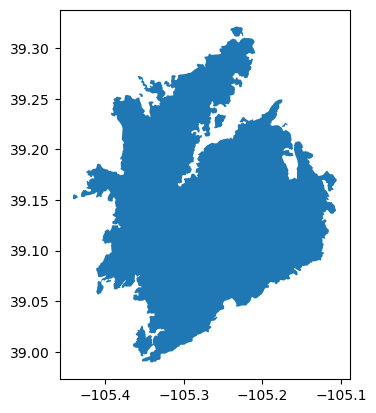

In [3]:
# Define our path
hayman_bound_path = BASE_DATA_PATH / "Hayman_MTBS_Datapackage/co3922010528720020608_20010824_20030814_burn_bndy.shp"
hayman_bounds_gdf = gpd.read_file(hayman_bound_path).to_crs(crs="EPSG:4326")
hayman_bounds_gdf.plot()

<Axes: >

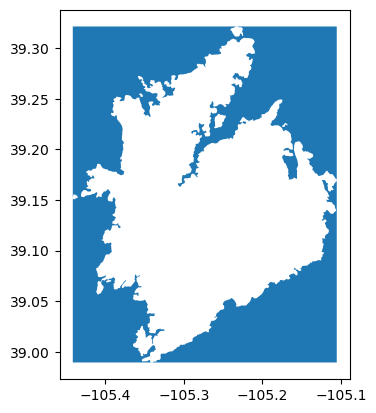

In [4]:
# Grab a box surrounding the area, with the area cut out.
bbox = box(*hayman_bounds_gdf.total_bounds)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=hayman_bounds_gdf.crs)
outside_hayman_bounds = gpd.GeoDataFrame(geometry=[bbox], crs=hayman_bounds_gdf.crs).overlay(hayman_bounds_gdf, how = "difference")
outside_hayman_bounds.plot()

Now we need to try and get all of our NDVI data imported.

In [12]:
NDVI_BASE_PATH = BASE_DATA_PATH / "NDVI"
years = os.listdir(NDVI_BASE_PATH)
min_lat = 38
max_lat = 39
min_lon = -104.5
max_lon = -105.5
#ndvi_years = []
#for year in years:
#    path = str(NDVI_BASE_PATH / year / "*.nc")
#    ds = xarray.open_mfdataset(path)
#    tup = (year,ds)
#    ndvi_years.append(tup)

#test_ds = test_ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(max_lon,min_lon))
#test_df = test_ds['NDVI'].to_dataframe().reset_index()
#gdf = gpd.GeoDataFrame(
#    test_df,
#    geometry=gpd.points_from_xy(test_df.longitude, test_df.latitude, crs="EPSG:4326")
#)

ndvi_years = []
for year in years:
    path = str(NDVI_BASE_PATH / year / "*.nc")
    ds = xarray.open_mfdataset(path)
    ds = ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(max_lon,min_lon))
    df = ds['NDVI'].to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:2232")
    )
    joined_gdf = (
        hayman_bounds_gdf
        .to_crs(gdf.crs)
        .sjoin(
            gdf,
            how="inner",
            predicate="contains"
        )
    )
    
    tup = (year,joined_gdf)
    ndvi_years.append(tup)


/tmp/ipykernel_44658/1186458569.py:24: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xarray.open_mfdataset(path)
/tmp/ipykernel_44658/1186458569.py:24: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xarray.open_mfdataset(path)
/tmp/ipykernel_44658/1186458569.py:24: FutureWarning: In a future version of

In [16]:
NDVI_BASE_PATH = BASE_DATA_PATH / "NDVI"
data = xarray.open_mfdataset(str(NDVI_BASE_PATH / "2002" /  "*.nc"), data_vars='all')
data = data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=False)
data = data.rio.write_crs("epsg:2232", inplace=True)


In [18]:
print(data.dims)
print(data.coords)

FrozenMappingWarningOnValuesAccess({'time': 31, 'latitude': 3600, 'nv': 2, 'longitude': 7200})
Coordinates:
    crs        int64 8B 0
  * latitude   (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) datetime64[ns] 248B 2002-07-01 2002-07-02 ... 2002-07-31


In [17]:
clipped = data.rio.clip(hayman_bounds_gdf.geometry, hayman_bounds_gdf.crs, drop=True)

MissingSpatialDimensionError: x dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'x' can address this. Data variable: lat_bnds

In [12]:
## Try with just one dataset
file = BASE_DATA_PATH / "NDVI" / "2001" / "AVHRR-Land_v005_AVH13C1_NOAA-16_20010701_c20170608114619.nc"
data = xarray.open_dataset(file)
data = data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=False)
data = data.rio.write_crs("EPSG:4326", inplace=False)
data = data["NDVI"]

In [13]:
print(data)

<xarray.DataArray 'NDVI' (time: 1, latitude: 3600, longitude: 7200)> Size: 207MB
[25920000 values with dtype=float64]
Coordinates:
    crs        int64 8B 0
  * latitude   (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) datetime64[ns] 8B 2001-07-01
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    standard_name:  normalized_difference_vegetation_index


In [14]:
clipped = data.rio.clip(hayman_bounds_gdf.geometry, hayman_bounds_gdf.crs, drop=True)


In [26]:
clipped[0]

<xarray.DataArray 'NDVI' (latitude: 6, longitude: 6)> Size: 288B
array([[   nan,    nan, 0.0557, 0.0808,    nan,    nan],
       [0.0529, 0.008 , 0.026 , 0.0388,    nan,    nan],
       [0.0457, 0.049 , 0.0337, 0.0346,    nan,    nan],
       [0.1607, 0.091 , 0.0682, 0.0618, 0.0603, 0.0599],
       [0.1979, 0.1558, 0.0546, 0.0358, 0.0547,    nan],
       [   nan, 0.149 , 0.0796,    nan,    nan,    nan]])
Coordinates:
  * latitude     (latitude) float32 24B 39.27 39.22 39.17 39.12 39.07 39.02
  * longitude    (longitude) float32 24B -105.4 -105.3 -105.3 ... -105.2 -105.1
    time         datetime64[ns] 8B 2001-07-01
    spatial_ref  int64 8B 0
    crs          int64 8B 0
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    standard_name:  normalized_difference_vegetation_index

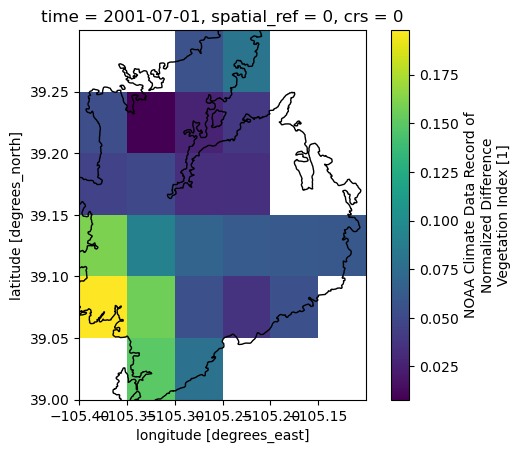

In [29]:
ax=hayman_bounds_gdf.plot(facecolor='none',edgecolor='black')
plot=clipped[0].plot(ax=ax,zorder=-1)
#plt.savefig('Pakistan.png',dpi=300)

In [37]:
# Opening the surface temp data
test_temp_path = BASE_TEMP_PATH / "MOD11A1.A2001210.h09v05.061.2020096190656.hdf"
test_temp = rxr.open_rasterio(test_temp_path, masked=True).squeeze()
type(test_temp)

xarray.core.dataset.Dataset

In [34]:
# Testing the pctg of NaN's to see if we actually even want to work with the data. 
counter = test_temp['LST_Day_1km']

test = counter.rio.reproject(hayman_bounds_gdf.crs)
no_fill_clip = test.rio.clip(bbox_gdf.geometry.apply(mapping),
                            crs=bbox_gdf.crs,
                            all_touched=True,
                            from_disk=True)
#no_fill_clip.plot()
#isnull = counter.isnull()
#isnull.sum()
isnull = no_fill_clip.isnull()
print(no_fill_clip.size)
print(isnull.sum().item())
print(f'Proportion of NaN to real values: {isnull.sum().item()/no_fill_clip.size}')

484
41
Proportion of NaN to real values: 0.08471074380165289


In [44]:
test_dx = xr.DataArray(dims="time", 

In [40]:
test_temp['LST_Day_1km'].scale_factor

0.02

In [43]:
dstart = -36
dend = -29
# Looping over all the data
one_surface_temps_data_paths = sorted(list(BASE_TEMP_PATH.rglob('*.hdf')))
# Set initial current year
curr_year = 2001
for path in one_surface_temps_data_paths:
    # Define date
    date = str(path)[dstart:dend]
    date = datetime.datetime.strptime(date, '%Y%j')
    # Open Data
    da = rxr.open_rasterio(path, masked=True).squeeze()
    # Determine if data is good enough to use. If not, skip rest of steps and move on to next file
    box = da['LST_Day_1km'].rio.reproject(hayman_bounds_gdf.crs)
    pre_interpolation_clip = box.rio.clip(bbox_gdf.geometry.apply(mapping),
                                          crs=bbox_gdf.crs,
                                          all_touched=True,
                                          from_disk=True)
    isnull = pre_interpolation_clip.isnull()
    pctg_null = isnull.sum().item()/pre_interpolation_clip.size
    if(pctg_null > 0.3):
        print(f'Skipping {date.day}, too many null values in box: {pctg_null}')
    else:
        # Interpolate missing values
        interp = da['LST_Day_1km'].interpolate_na(dim='x')
        interp = interp.sortby('y')
        interp = interp.interpolate_na(dim='y')
        interp = interp.sortby('y', ascending=False)
        # Project to workable crs
        reproject = interp.rio.reproject(hayman_bounds_gdf.crs)
        # Clip inside
        inner_clip = reproject.rio.clip(hayman_bounds_gdf.geometry.apply(mapping),
                                        crs=hayman_bounds_gdf.crs,
                                        all_touched=False,
                                        from_disk=True)
        # Clip outside
        outer_clip = reproject.rio.clip(outside_hayman_bounds.geometry.apply(mapping),
                              crs=hayman_bounds_gdf.crs,
                              all_touched=True,
                              from_disk=True)
        # Store in array. 
        print(f'Date: {date.date()} Inner mean: {inner_clip.mean().item()*inner_clip.scale_factor} Outer mean: {outer_clip.mean().item()*outer_clip.scale_factor}')

Skipping 3, too many null values in box: 1.0
Skipping 4, too many null values in box: 0.8636363636363636
Date: 2001-07-05 Inner mean: 304.85837890625 Outer mean: 304.63283203125
Skipping 6, too many null values in box: 0.384297520661157
Date: 2001-07-07 Inner mean: 303.61630859375003 Outer mean: 303.5173828125
Date: 2001-07-08 Inner mean: 308.91302734375 Outer mean: 308.27240234375
Skipping 9, too many null values in box: 0.3739669421487603
Date: 2001-07-10 Inner mean: 304.30636718750003 Outer mean: 302.55705078125
Skipping 11, too many null values in box: 0.7355371900826446
Skipping 12, too many null values in box: 0.3987603305785124
Skipping 13, too many null values in box: 0.8037190082644629
Skipping 14, too many null values in box: 1.0
Skipping 15, too many null values in box: 0.8202479338842975
Date: 2001-07-16 Inner mean: 300.87193359375 Outer mean: 299.44228515625
Skipping 17, too many null values in box: 0.9958677685950413
Date: 2001-07-18 Inner mean: 297.82234375 Outer mean: 2

In [6]:
# Interpolating to account for NaN's
interpolate = test_temp['LST_Day_1km'].interpolate_na(dim='x')
interpolate = interpolate.sortby('y')
interpolate = interpolate.interpolate_na(dim='y')
interpolate = interpolate.sortby('y', ascending=False)

In [9]:
# Reprojecting to get in CRS we want
reproject = interpolate.rio.reproject(hayman_bounds_gdf.crs)

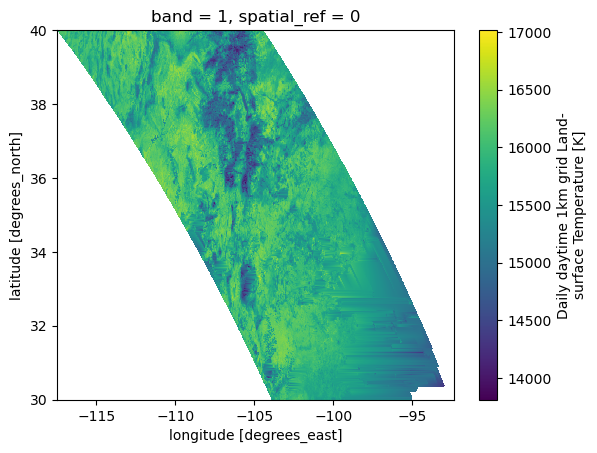

In [10]:
reproject.plot()

In [17]:
# Clipping to inside and outside of fire bounds
temp_clip = reproject.rio.clip(hayman_bounds_gdf.geometry.apply(mapping),
                              crs=hayman_bounds_gdf.crs,
                              all_touched=False,
                              from_disk=True)

temp_clip_outside = reproject.rio.clip(outside_hayman_bounds.geometry.apply(mapping),
                              crs=hayman_bounds_gdf.crs,
                              all_touched=True,
                              from_disk=True)

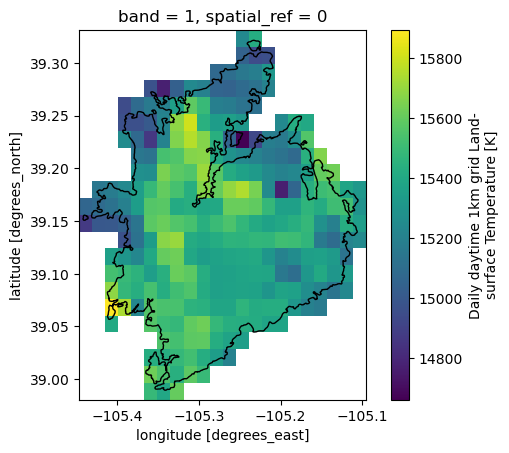

In [14]:
ax=hayman_bounds_gdf.plot(facecolor='none',edgecolor='black')
plot = temp_clip.plot(ax=ax, zorder=-1)

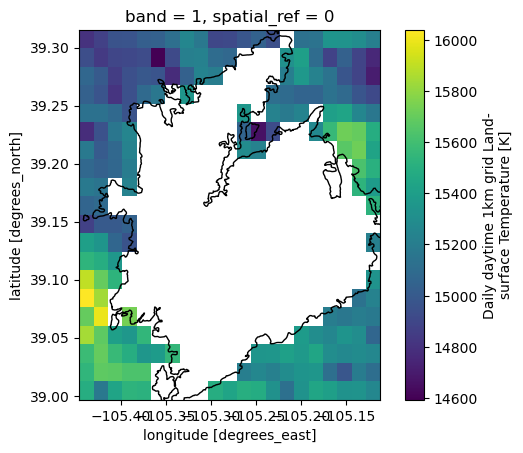

In [18]:
ax=hayman_bounds_gdf.plot(facecolor='none',edgecolor='black')
plot = temp_clip_outside.plot(ax=ax, zorder=-1)